<a href="https://colab.research.google.com/github/luisfranc123/Tutorials_Statistics_Numerical_Analysis/blob/main/Applied_Statistics/Poisson_Regression_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**The Poisson Regression**
---

###**What Are Poisson Regression Models?**
Poisson Regression models are best used to model events where the outcomes are counted. More specifically, count data consists of discrete data with non-negative integer values that count something, like the number of times an event occurs during a given timeframe or the number of people in line at the grocery store.

Count data can also be expressed as rate data, since the number of times an event occurs within a timeframe can be expressed as a raw count (i.e. "In a day, we eat three meals") or as a rate ("We eat at a rate of 0.125 meals per hour").

Poisson Regression helps us analyze both count and rate data by allowing us to determine which explanatory variables (X values) affect a given response variable (Y value, the count, or a rate). For example, a grocery store could apply Poisson regression to better understand and predict the number of people in a line.

###**What is Poisson Distribution?**

Poisson distribution is a statistical theory named after French mathematician Siméon Denis Poisson. It models the probability of event or events occurring within a specific timeframe, assuming that $y$ occurrences are not affected by the timing of previous occurrences of $y$. This can be expressed mathematically using the following formula:

\begin{align}
P(y)=\frac{e^{-\mu{t}}(\mu{t})^{y}}{y!}
\end{align}

where $y$ = 0, 1, 2, 3...

Here, μ (in some textbooks you may see λ instead of μ) is the average number of times an event may occur per unit of exposure. It is also called the parameter of Poisson distribution. The exposure may be time, space, population size, distance, or area, but it is often time, denoted with t. If exposure value is not given it is assumed to be equal to 1.

##**Poisson Regression in Python**
---

![Arrest](https://beyondcourts.org/sites/default/files/2022-06/1%20-%20arrest%20-%20precinct.png)

###**Setup**

In [ ]:
# This code enable us to have access to the Drive environment
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

data_loc = "/content/drive/MyDrive/Francisco/GC_Material/Biostatistics_10/Term III/frisk_with_noise.dat"
data = pd.read_csv(data_loc, skiprows = 6, delimiter = " ")
data.sample(5) # Print a random sample.


,stops,pop,past.arrests,precinct,eth,crime
599,4,611,13,50,3,4
406,243,62100,142,34,3,3
844,196,39395,264,71,2,1
304,92,63458,883,26,2,1
101,25,3919,25,9,2,2


The data consists of stop-and-frisk data with noise added to protect confidentiality. This is important because it means that the estimates here will not reproduce the exact same results as in the book or the article. But the lessons of it remain true. Here's a quick description of the data.

- **stops**: The number of police stops between January 1998 and March 1999, for each combination of precinct, ethnicity and type of crime.
- **pop**: The population.
- **past.arrests**: The number of arrests that took place in 1997 for each combination of precinct, ethnicity and type of crime.
- **precinct**: Index for the precinct (1-75).
- **eth**: Indicator for ethnicity, black (1), hispanic (2), white (3). Other ethnic groups were excluded because ambiguities in the classification would cause large distortions in the analysis.
- **crime**: Indicator for the type, violent (1), weapons (2), property (3), drug (4).


In a Poisson model, each observation corresponds to a setting like a location or a time interval. In this example, the setting is precinct and ethnicity - these two are indexed with the leter *i*. **The response variable that we want to model, $y$, is the number of police stops**.

Poisson regression is an example of a generalized linear model (GLM), so, like in **ordinary linear regression** or like in **logistic regression**, we model the variation in $y$ with some linear combination of predictors, $X$.


\begin{align}
y_{i} ∼ Poisson(\theta_{i})
\end{align}

\begin{align}
\theta_{i} = e^{X_{i}β}
\end{align}

\begin{align}
{X_{i}β = β_{0} + X_{i,1}β_{1} + X_{i,2}β_{2} + ... + X_{i,k}β_{k}}
\end{align}

The notation implicitly assumes that $X_{i,0} = 1$ for all observations, just so that we don't have to write the intercept term separately. The use of the exponential in second row is needed because the parameter passed to the Poisson distribution has to be a positive number. The linear combination $X_{i}β$ is not contrained to be positive, so the exponential isused a *link* to the allowed parameters.

The model above would work just fine, but it is most common to model $y$ as relative to some baseline variable $u$. This baseline variable is also called the *exposure*. Thereby, the model we use is given by the following expression:

\begin{align}
y_{i}=Poisson(u_{i}\theta_{i})=Poisson(exp(X_{i}\beta + log(u_{i})))
\end{align}

In other words, the logarithm of the exposure plays the role of an offset term.



We first need to put our data in the right shape.

In [ ]:
X = (data
    .groupby(['eth', 'precinct'])[["stops", "past.arrests"]]
    .sum()
    .reset_index()
    .pipe(pd.get_dummies, columns=['eth', 'precinct'], dtype = 'int64')
    .assign(intercept=1)  # Adds a column called 'intercept' with all values equal to 1.
    .sort_values(by='stops')
    .reset_index(drop=True)
)

y = X.pop("stops")

In [ ]:
print(X)
print("========")
print(y)

     past.arrests  eth_1  eth_2  eth_3  precinct_1  precinct_2  precinct_3  \
0              16      1      0      0           0           0           0   
1              97      0      0      1           0           0           0   
2             338      0      0      1           0           0           0   
3             115      0      0      1           0           0           0   
4              44      0      0      1           0           0           0   
..            ...    ...    ...    ...         ...         ...         ...   
220          2166      0      1      0           0           0           0   
221          3468      1      0      0           0           0           0   
222          4209      1      0      0           0           0           0   
223          4540      1      0      0           0           0           0   
224          4411      1      0      0           0           0           0   

     precinct_4  precinct_5  precinct_6  ...  precinct_67  prec

###**Poisson Regression**

####**Offset and constant term only**

First we fit the model without any predictors,

\begin{align}
y_{i} ∼ Poisson(exp(\beta_{0} + log(u_{i}))).
\end{align}

We use the library `scikit-learn` to fit the model.

In [ ]:
model_no_indicators = sm.GLM(
    y,
    X["intercept"],
    offset=np.log(X["past.arrests"]),
    family=sm.families.Poisson(),
)
result_no_indicators = model_no_indicators.fit()
print(result_no_indicators.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  stops   No. Observations:                  225
Model:                            GLM   Df Residuals:                      224
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23913.
Date:                Fri, 21 Mar 2025   Deviance:                       46120.
Time:                        15:40:26   Pearson chi2:                 4.96e+04
No. Iterations:                     5   Pseudo R-squ. (CS):         -6.461e-14
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.5877      0.003   -213.058      0.0

Let's plot the observed values vs the fitted values. The fitted values are conveniently stored in the `fittedvalues` attribute of the result.

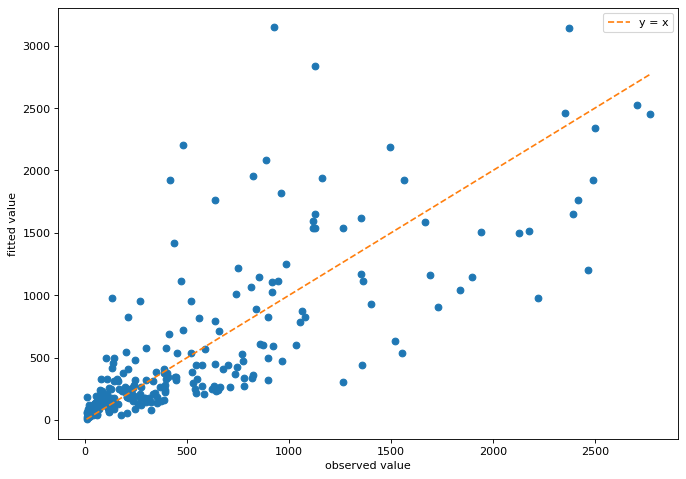

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(10, 7), dpi=80)
plt.plot(y, result_no_indicators.fittedvalues, 'o')
plt.plot(y, y, '--', label = 'y = x')
plt.ylabel("fitted value")
plt.xlabel("observed value")
plt.legend()
plt.show()

Perhaps, not as bad as we would've expected for a 1 parameter model. Let's extent the model to include two more parameters.

###**Ethnicity and precinct as predictors**

We build on top of the previous model by first adding the ethnicity indicators. Note that we don't add the ethnicity indicator for black (1) because we use it as the baseline.

In [ ]:
# Model with ethnicity
model_eth = sm.GLM(
    y,
    X[['intercept', 'eth_2', 'eth_3']],
    offset = np.log(X['past.arrests']),
    family = sm.families.Poisson(),
)
results_eth = model_eth.fit()
print(results_eth.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  stops   No. Observations:                  225
Model:                            GLM   Df Residuals:                      222
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23572.
Date:                Fri, 21 Mar 2025   Deviance:                       45437.
Time:                        15:40:26   Pearson chi2:                 4.94e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9519
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.5881      0.004   -155.396      0.0

Adding the two ethnicity indicators as predictors decreased the deviance by $46120-45437=683 (units)$. **Keep in mind that if ethnicity indicators were just noise, we should expect a decrease in deviance of around 2 units**. *Besides, noth coefficients are significant*.



Finally, let's also control for precinct (we use `precinct_1` as the baseline).

In [ ]:
model_eth_prec = sm.GLM(
    y,
    X.drop(columns = ["eth_1", "precinct_1", "past.arrests"]),
    offset = np.log(X["past.arrests"]),
    family = sm.families.Poisson(),
)
results_eth_prec = model_eth_prec.fit()
print(results_eth_prec.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  stops   No. Observations:                  225
Model:                            GLM   Df Residuals:                      148
Model Family:                 Poisson   Df Model:                           76
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2566.9
Date:                Fri, 21 Mar 2025   Deviance:                       3427.1
Time:                        15:40:26   Pearson chi2:                 3.24e+03
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
eth_2           0.0102      0.007      1.498      

We can check out the massive decrease in the `Deviance` (from **45437** to **3427.1**) - precinct factors (e.g., location of police stops) are definitely not noise. Now we can observe that the stop rates for black and hispanic are very similar, while whites are 34% less likely to be stopped.The latter is because we get a 34% from the estimated coefficient:

\begin{align}
e^{-0.419}≈0.66=1-0.34.
\end{align}

**1. Understanding the Poisson Regression and the Exponential Formula**

- Poisson regression models count data (e.g., the number of times an event occurs).
- The model predicts the log of the expected count as a function of independent variables:
\begin{align}
log⁡(E(Y))=β0+β1X1+β2X2+…,
\end{align}
where $E(Y)$ is the expected count (e.g., number of police stops).
- Since the model uses log-transformed expected counts, we need to exponentiate the coefficient to interpret its impact on the expected count.

**2. Applying the Interpretation to Stop Rates**

- The coefficient of -0.419 (for white individuals) tells us the effect of race on the expected number of stops.
- To convert this back into **multiplicative terms**, we exponentiate it:
\begin{align}
e^{-0.419}\approx 0.66
\end{align}

- This means that the expected **number of stops** for **White individuals** is 66% of the expected stops for **Black** or **Hispanic individuals**.
- Equivalently, White individuals experience 34% **fewer stops** than **Black** or **Hispanic** individuals:

\begin{align}
1-0.66 = 0.34 = 34%
\end{align}
reduction.

**3. Key Takeaways for Poisson Regression Interpretation**

- Poisson regression models counts (not probabilities), so we interpret the coefficient in terms of expected number of events (stops).
- Exponentiating the coefficient (-0.419) gives us a multiplicative effect on the stop rate: White individuals are stopped at 66% of the rate of Black or Hispanic individuals.
- A negative coefficient means a decrease in expected stops: A 34% lower rate of stops for White individuals.



With so many precincts, we might find it easier to see the estimated coefficients in a plot.

In [ ]:
precinct_coefs = results_eth_prec.params
precinct_interval = results_eth_prec.conf_int().reindex(precinct_coefs.index)
precinct_interval

,0,1
eth_2,-0.003144,0.023520
eth_3,-0.437493,-0.400509
precinct_2,-0.294146,-0.003953
precinct_3,0.448710,0.671199
precinct_4,1.097842,1.323430
...,...,...
precinct_72,1.359662,1.570308
precinct_73,0.885992,1.096043
precinct_74,1.037737,1.265183
precinct_75,1.422794,1.719656


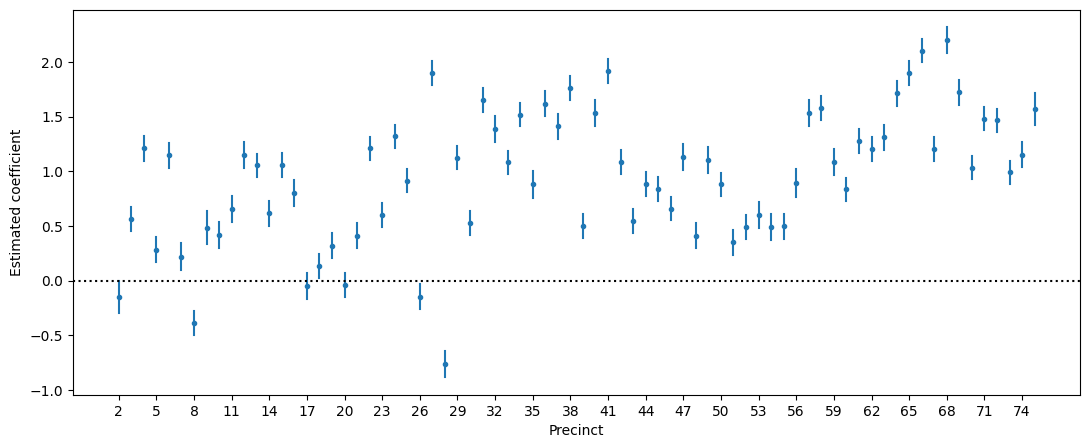

In [ ]:
precinct_coefs = results_eth_prec.params.iloc[2:-1] # Only intersted in precinct
precinct_interval = results_eth_prec.conf_int().reindex(precinct_coefs.index)

plt.figure(figsize=(13, 5))
plt.plot(precinct_coefs, '.')

for precinct, interval in precinct_interval.iterrows():
    plt.plot([precinct, precinct], interval, color='C0')
plt.axhline(y=0, linestyle=':', color='black')
plt.xticks(
    precinct_coefs.index[::3],
    [int(x[1]) for x in precinct_coefs.index.str.split("_",)][::3]
)
plt.ylabel("Estimated coefficient")
plt.xlabel("Precinct")
plt.show()


We can observe that most coefficients are significant (i.e. do not include zero within their interval). Let's now compare the fitted values of the models with ethnicity and the one including ethnicity and precinct, respectively.   

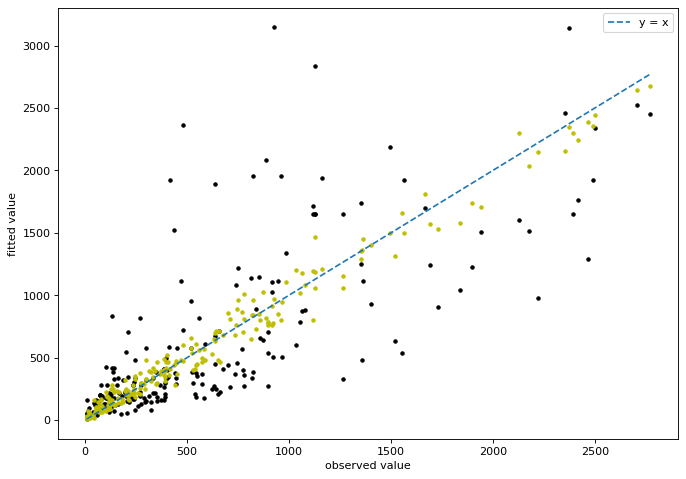

In [ ]:
figure(figsize=(10, 7), dpi=80)
plt.plot(y, results_eth.fittedvalues, '.', color = 'k')
plt.plot(y, results_eth_prec.fittedvalues, '.', color = 'y')
plt.plot(y, y, '--', label='y = x')
plt.ylabel("fitted value")
plt.xlabel("observed value")
plt.legend()
plt.show()

###**Overdispersed Poisson**

The Poisson distribution does not have independent parameter for the variance like, say, a normal distribution. Turns out that for the Poisson distribution, $y∼Poisson(\lambda)$, the variance is equal to the mean.

\begin{align}
E(y)=\lambda
\end{align}
\begin{align}
Var(y)=\lambda
\end{align}

This means that we can easily evauate if our data follows a Poisson distribution or not. *We already knnow that thet residuals of your fit should have mean equal to zero. We can go a bit further and look at the standardized residuals*.

\begin{align}
z_{i} = \frac{y_{i}-\mu}{\sigma}
\end{align}

\begin{align}
 = \frac{y_{i}-\hat{y_{i}}}{\sqrt{\hat{y_{i}}}}
\end{align}

which not only have mean at zero, but also standard deviation equal to **1**.

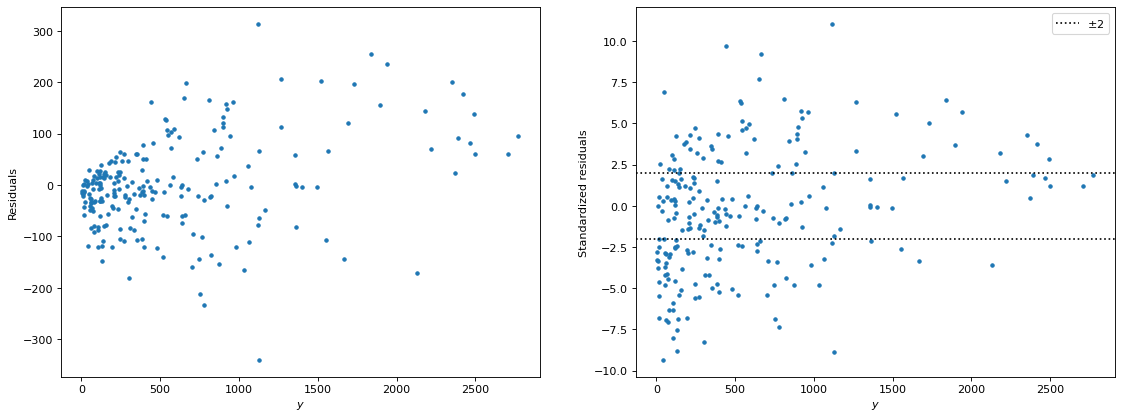

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(17, 6), dpi = 80)
axes[0].plot(y, results_eth_prec.resid_response, '.')
axes[0].set_ylabel("Residuals")
axes[0].set_xlabel("$y$")
axes[1].plot(y, results_eth_prec.resid_pearson, '.')
axes[1].axhline(y=-2, linestyle=':', color='black', label='$\pm 2$')
axes[1].axhline(y=+2, linestyle=':', color='black')
axes[1].set_ylabel("Standardized residuals")
axes[1].set_xlabel("$y$")
plt.legend()
plt.show()

From the left plot, we observe tha the variance increases with the fitted values - as expected from a Poisson distribution. **However, if the data were well described by the Poisson model, 95% of the standardized residuals should lie within 2 standard deviations. This is not the case (right plot)**.

to quantify this, the number we should look at is the *overdispersion ratio $R$*, which is

\begin{align}
R = \frac{1}{n-k}\Sigma{z^2_{i}},
\end{align}

where $n-k$ are the degrees of freedom of the residuals ($n$ is the number of observations and $k$ is the number of parameters we used in the model). If the data were Poisson, we would expect $R\approx1$. When $R>0$, we establish that the data is **overdispersed**. When $R<1$, we establish that the data is **under-dispersed**.



In [ ]:
R = results_eth_prec.pearson_chi2/results_eth_prec.df_resid
print(f'Overdispersion R = {R:.2f}')

Overdispersion R = 21.89


##**Poisson Distribution Behavior**
---

Let's visualize the Poisson by creating a Poisson distribution plot for different values of $\lambda$:


In [ ]:
# We first create a nested iteration to calculate the probabilities given
# distinct λ values depending on event rangong from 1 to 20.
import numpy as np
import math
a = [1, 2, 3, 4, 5, 6] # Vector for values of mu(u) - λ - Poisson Parameter
b = np.linspace(1, 20, 20).tolist()
b = list(map(int, b))
b
probabilities = []
for i in a:
  group = []
  mu = i + 1 # Adjusted mu (λ) value

  for j in b:
    p = ((math.exp(-mu))*(mu**j))/(math.factorial(j))
    j += 1
    group.append(p)
  probabilities.append(group)


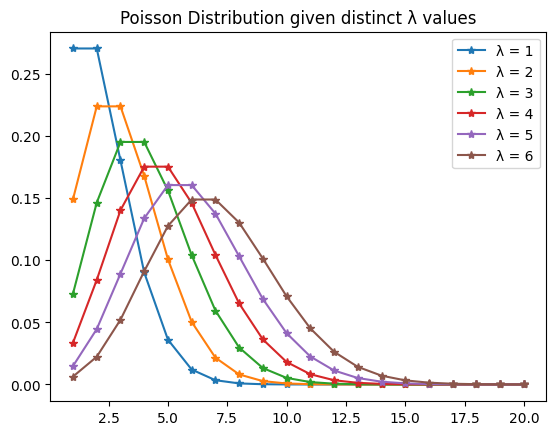

In [ ]:
for i in range(len(probabilities)):
  plt.plot(b, probabilities[i], label = f"λ = {i+1}", marker= "*")
  i += 1
#plt.plot(x, y1, "-b", label="sine")
#plt.plot(x, y2, "-r", label="cosine")
#plt.legend(loc="upper left")

plt.legend(loc = "upper right")
plt.title('Poisson Distribution given distinct λ values')
plt.show()